# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [A] K-Means Clustering

# Import Required Packages

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# package for reading from database
import sqlite3

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data prerocessing related
from sklearn.preprocessing import StandardScaler

# for computing distances betweeen data points
from sklearn.metrics import pairwise_distances

# import model related packages
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# visualization related packages
from wordcloud import WordCloud
from prettytable import PrettyTable

# UTIL Functions

## Data Preprocessing related Functions

In [2]:
def preprocess_data(config_dict, scaling=True, dim_reduction=False):
    """
    This function does preprocessing of data such as column standardization and
    dimensionality reduction using Truncated SVD
    """
    
    # Read train, test data frames & truncate it as needed
    train_df = pd.read_csv(config_dict['train_csv_path'], index_col=False)
    train_df = train_df.iloc[0:config_dict['train_size']]
    
    # print the statisics of train, test df
    print('Train df shape',train_df.shape)

    # separate features and labels
    id_values = train_df['Id']
    train_features = train_df.drop(['Label', 'Id'], axis=1)
    
    # get feature names as list
    feature_name_list = train_features.columns.values.tolist()
    
    # If Scaling is opted scale the train, test data
    if scaling:
        standard_scaler = StandardScaler()
        standard_scaler.fit(train_features)
        # scale the features
        train_features = pd.DataFrame(standard_scaler.transform(train_features),
                                      columns=feature_name_list)
        
    train_features['Id'] =  id_values                        
    print('Shape of ->  train features :%d,%d '%train_features.shape)
    
    # if dim reduction is opted, reduce the dimension
    if dim_reduction:
        # create an SVD object
        truc_svd = TruncatedSVD(n_components=train_features.shape[1]-1, n_iter=8, algorithm='randomized')

        # fit to data
        truc_svd.fit(train_features)
        # get explained variance ratio of each component
        explained_var_ratios = truc_svd.explained_variance_ratio_
        # get cummulative ratio list for selecting the number of components
        cumulative_ratios = np.cumsum(explained_var_ratios)

        # plot the #components vs captured variance in the data
        plt.title('SVD Decomposition')
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative Percentage Ratio')
        plt.plot(range(1,train_features.shape[1]), cumulative_ratios)
        plt.show()

        # set a threshold for stopping selection of components.
        svd_thesh = 0.001
        # select the number of components as the first component for which the difference between cummulative ratio is
        #  very less (less than svd thresh) compared with the very next component
        selected_dim = list(filter(lambda x : x[1] < svd_thesh, enumerate(np.diff(cumulative_ratios))))[0][0]
        print('Num dimensions selected by SVD', selected_dim)
        print('Total variance captured:%f'%(cumulative_ratios[selected_dim]))

        # create an object for selecting the components
        truc_svd = TruncatedSVD(n_components=selected_dim, n_iter=8, algorithm='randomized')
        # refit with the desired number of components
        truc_svd.fit(train_features)

        # reduce the number of dimensions to selected number of components
        train_features = pd.DataFrame(truc_svd.transform(train_features))
        
        # get the shape of final data frame and print it
        print('Shape of train df:(%d,%d)'%train_features.shape)

    
    return train_features

## Model training and evaluation related functions

In [3]:
def find_best_hyperparameter(config_dict, train_features):
    
    """
    This function helps to find the best hyper parameter for the clustering algorithm.
    All set of hyper param values using which the model to be evaluated can be passed to the
    list hyperparam_list. It also takes algo_type which can be one among k-means, agglomeretive
    or DBSCAN.
    """
    
    print('='*100)
    
    hyperparam_list = config_dict['hyperparam_list']
    algo_type = config_dict['algo_type']
    
    # set the input for training
    X_train = train_features.drop(['Id'], axis=1)
    
    hyper_param_score_list = list()
    inertia_score_list = list() # for k-means algorithm

    for hyp_vals in hyperparam_list:

        # Model defined here
        if algo_type == 'kmeans':
            
            # create an object of clustering algorithm
            clustering_model = KMeans(n_clusters=hyp_vals, init='k-means++', n_init=10)
            
            # fit on data
            clustering_model.fit(X_train)
            # get the inertia value as score
            inertia_val = clustering_model.inertia_
            
            # get the silhouytte score for this clustering
            if len(set(clustering_model.labels_)) == 1:
                sil_score = -1
            else:    
                sil_score = silhouette_score(X_train, clustering_model.labels_)
                
            # append hyper param scores
            inertia_score_list.append((hyp_vals, inertia_val,))
            hyper_param_score_list.append((hyp_vals, sil_score,))

        elif algo_type == 'agglomerative':
            
            # create clustering algorithm object
            clustering_model = AgglomerativeClustering(n_clusters=hyp_vals)
            # fit on data
            clustering_model.fit(X_train)
            
            # get the silhouytte score for this clustering
            if len(set(clustering_model.labels_)) == 1:
                sil_score = -1
            else:    
                sil_score = silhouette_score(X_train, clustering_model.labels_)
            
            sil_score = silhouette_score(X_train, clustering_model.labels_)
            
            # append hyper param scores
            hyper_param_score_list.append((hyp_vals, sil_score,))
            
        elif algo_type == 'dbscan':
            
            # hyper params in the order (eps, min_samples,)
            clustering_model = DBSCAN(eps=hyp_vals[0], min_samples=hyp_vals[0], metric='euclidean')
            # fit on data
            clustering_model.fit(X_train)
            # get the inertia value as score
            
            if len(set(clustering_model.labels_)) == 1:
                sil_score = -1 # minimum possible silhoutte score
                
            else:    
                sil_score = silhouette_score(X_train, clustering_model.labels_)
            
            # append hyper param scores
            hyper_param_score_list.append((hyp_vals, sil_score,))
            
        else:
            print('Invalid choice')
    
    # plot inertia vs k for k-means clustering
    if algo_type == 'kmeans':
        # plot k versus inertia
        inertia_values_list = [item[1] for item in inertia_score_list] 
        plt.plot(hyperparam_list, inertia_values_list)
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia Value')
        plt.title('Elbow Method')
        plt.show()
                
    return hyper_param_score_list

In [4]:
def get_cluster_id(config_dict, score_list, train_features):
    
    """
    This function fit a model based on best hyper parameter values got and
    assign cluster id to each data point.
    """
    
    # get the best hyperparams from the list
    hyp_vals, hyp_score = max(score_list, key=lambda x: x[1])

    # get configuration values
    hyperparam_list = config_dict['hyperparam_list']
    algo_type = config_dict['algo_type']
    
    # Model defined here
    if algo_type == 'kmeans':
        print('Best hyper param selected n_clusters : %d '%hyp_vals)
        print('Best silhoutte score for this hyper parameter : %f'%hyp_score)
        clustering_model = KMeans(n_clusters=hyp_vals, init='k-means++', n_init=10)
        # set entry for putting in table
        hyp_str = 'k= '+ str(hyp_vals)
        
    elif algo_type == 'agglomerative':
        print('Best hyper param selected n_clusters : %d'%hyp_vals)
        print('Best silhoutte score score for this hyper parameter : %f'%hyp_score)
        clustering_model = AgglomerativeClustering(n_clusters=hyp_vals)
        # set entry for putting in table
        hyp_str = 'k= '+ str(hyp_vals)
        
    elif algo_type == 'dbscan':
        # hyper params in the order (eps, min_samples,)
        print('Best hyper param selected eps:%f,min_samples :%d'%hyp_vals)
        print('Best silhoutte score score for this hyper parameter : %f'%hyp_score)
        clustering_model = DBSCAN(eps=hyp_vals[0], min_samples=hyp_vals[1], metric='euclidean')
        
        # set entry for putting in table
        hyp_str = 'eps= %.4f, min_pts= %d '%hyp_vals
        
    else:
        print('Invalid choice')
    
    X_train = train_features.drop(['Id'], axis=1)
    
    clustering_model.fit(X_train)
    
    # get the labels for each data point (i.e cluster id)
    assigned_cluseter_ids = clustering_model.labels_
    
    # create a data frame with review ID and its predicted cluster
    pred_df = pd.DataFrame({'Id': train_features['Id'], 
                            'Cluster' : assigned_cluseter_ids}, 
                           index=range(train_features.shape[0]))
    
    # set the clustering size info as a string
    cluster_info = str(dict(pred_df['Cluster'].value_counts()))
    
    # form a table entry to insert into pretty table
    table_entry = [cluster_info, hyp_str, '{0:.4f}'.format(hyp_score)]
    
    return (table_entry, pred_df,)
    

In [5]:
def get_kdistance_plot(df, k_val):
    """
    This function returns a k-distance plot for a given data frame. It compute all pairwise distances
    and then compute avegare k-distances. It also finds the eps_val for DBSCAN algorithm.
    """
    
    # compute pairwise distances and create a distance data frame
    pair_dist_df = pd.DataFrame(pairwise_distances(df))
    pair_dist_df.shape[0]

    # declare a list for hodling mean k-distances
    mean_k_distance_list = list()

    # for each data point compute the k-mean distance
    for index, row in pair_dist_df.iterrows():

        # drop the distance to the point itself 
        temp_entry = row.drop([index])

        # sort the values in ascending order of distance
        temp_entry = temp_entry.sort_values(ascending=True)
        # pick the first k_val points as the k distance 
        temp_entry = temp_entry.iloc[0:k_val]

        # compute the mean k distance
        mean_k_distance = temp_entry.mean()

        # save the k mean distance for this point into a list
        mean_k_distance_list.append(mean_k_distance)

    # sort the k-mean distance in descending order
    mean_k_distance_list = sorted(mean_k_distance_list, reverse=True)
    
    # find eps value by looking into the sudden chnage in distance
    maxima_diff_list = list(filter(lambda x : x > 0.005, abs(np.diff(mean_k_distance_list))))
    eps_val = mean_k_distance_list[len(maxima_diff_list)]

    # plot the k-mean distances in a figure
    plt.plot(range(1, pair_dist_df.shape[0] + 1), mean_k_distance_list)
    plt.xlabel('Data Points')
    plt.ylabel('K distance')
    plt.title('K distance plot -> k:%d, eps:%f'%(k_val, eps_val,))
    plt.show()
    
    return (mean_k_distance_list, eps_val,)

## Functions for preparing word cloud of each cluster

In [6]:
def read_from_DB(id_list):
    """
    This function reads the Cleaned Review Text and its id into a data frame and returns it
    """
    
    # create a connection object for connecting with DB
    con = sqlite3.connect('/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/final.sqlite')
    
    # 
    df = pd.read_sql_query('SELECT Id, CleanedText, Summary, Label from Reviews', con)
    
    # get only the selected id and the correspondig CleanedText
    df = df[df['Id'].isin(id_list)]
    df = df[['Id', 'CleanedText', 'Label']]
    
    # close the connection
    con.close()
    
    return df

In [7]:
def get_cluster_wordcloud(pred_cluster_df, review_id_df):
    """
    This function shows the word cloud for each cluster given the predicted cluster information.
    """
    
    # create a word cloud template for each cluster word cloud
    wc = WordCloud(background_color='white', width=800, height=800)
    
    # do word cloud for each cluster
    for gid, gdf in pred_cluster_df.groupby(['Cluster']):
        
        print('='*100)
        
        # get id of each data point in this cluster
        id_list = gdf['Id'].tolist()
        
        # filter only the selected id reviews
        selected_rev_df = review_id_df[review_id_df['Id'].isin(id_list)]
        # get the class (+ve, -ve) of each ID
        val_counts_dict = dict(selected_rev_df['Label'].value_counts())
        
        # get the majority class for this cluster
        num_pos_rev = val_counts_dict[1]
        num_neg_rev = val_counts_dict[0]
        majority_class = 'Positive' if num_pos_rev > num_neg_rev else 'Negative'
        
        # print a table containing information about this cluster
        Pret_table_c = PrettyTable()
        Pret_table_c.field_names = ['Cluster_ID', 'Num Data Points', '# +ve Reviews', 
                                  '# -ve Reviews', 'Majority Class']
        Pret_table_c.title = 'Cluster %d Info'%(gid,)
        
        Pret_table_c.add_row([gid, gdf.shape[0], val_counts_dict[1], val_counts_dict[0], 
                              majority_class])
        print(Pret_table_c)
                                                                                  
        
        # initialize a text for this cluster, this will hold all the words that belong to this cluster
        cluster_text = str()
        
        for rev_txt in selected_rev_df['CleanedText']:
            cluster_text += rev_txt
            
        # generate word cloud for this cluster
        wc_output = wc.generate(cluster_text)
        
        plt.figure(figsize=(8,8))
        plt.imshow(wc_output)
        plt.axis('off')
        plt.title('Word Cloud for Cluster ID: %d'%(gid,))
        plt.tight_layout(pad=0.0)
        plt.show()
        
        print('='*100)

### [A.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [8]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/train_bow_bigram.csv',
    'train_size' : 15000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'kmeans'
}

Train df shape (15000, 503)
Shape of ->  train features :15000,502 


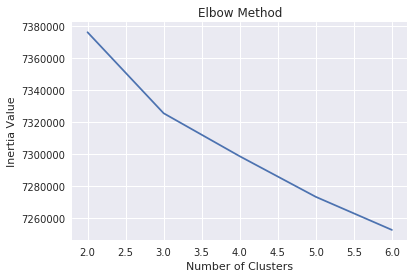

In [9]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

In [10]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.35220317632255554), (3, 0.20534017832980486), (4, 0.1498655129908616), (5, 0.1423849119228802), (6, 0.1502951676156047)]


In [11]:
ptabe_entry_a1, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 2 
Best silhoutte score for this hyper parameter : 0.352203


Id  Cluster
0  456873        1
1   81416        0
2  519340        0
3  340949        0
4  453782        0

### [A.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |      13051      |      6551     |      6500     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


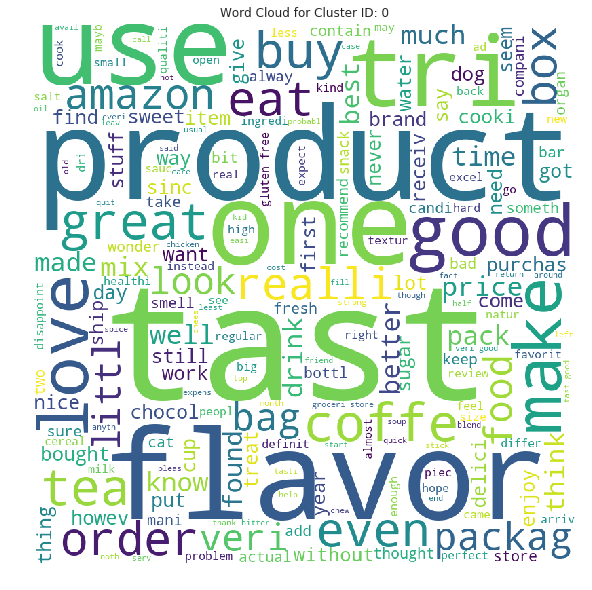

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       1949      |      873      |      1076     |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


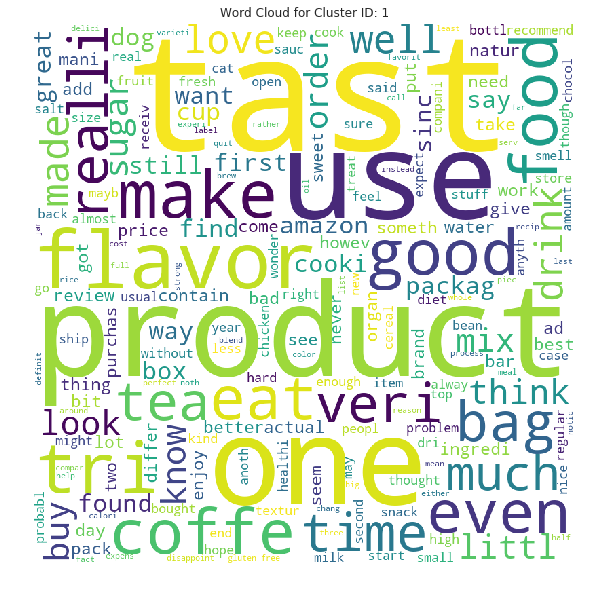

In [12]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation

%%HTML
<ul>
<li> Inertia value decreases sharply without any elbow region </li>
<li> Silhouette coefficient can be used to select the number of clusters, in this case k=2 for which we
     got the best score </li>
<li> Both clusters have many words in common. This means its not the word but a pattern of word
     that distinguishes the cluster. We cannot simply relay on just one feature to do clustering </li>
</ul>

### [A.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [13]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/train_bigram_tfidf.csv',
    'train_size' : 15000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'kmeans'
}

Train df shape (15000, 503)
Shape of ->  train features :15000,502 


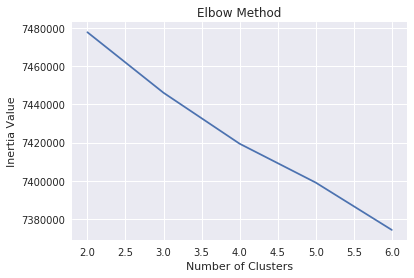

In [14]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

In [15]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.005332590945988098), (3, 0.0035891003118323508), (4, 0.0048517343200489595), (5, -0.010070153996622217), (6, -0.013397828732057769)]


In [16]:
ptabe_entry_a2, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 2 
Best silhoutte score for this hyper parameter : 0.005333


Id  Cluster
0  456873        0
1   81416        0
2  519340        1
3  340949        1
4  453782        0

### [A.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       6780      |      2923     |      3857     |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


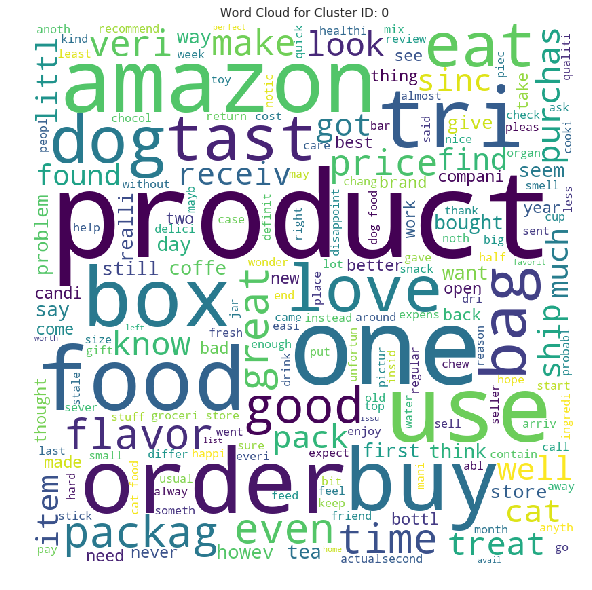

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       8220      |      4501     |      3719     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


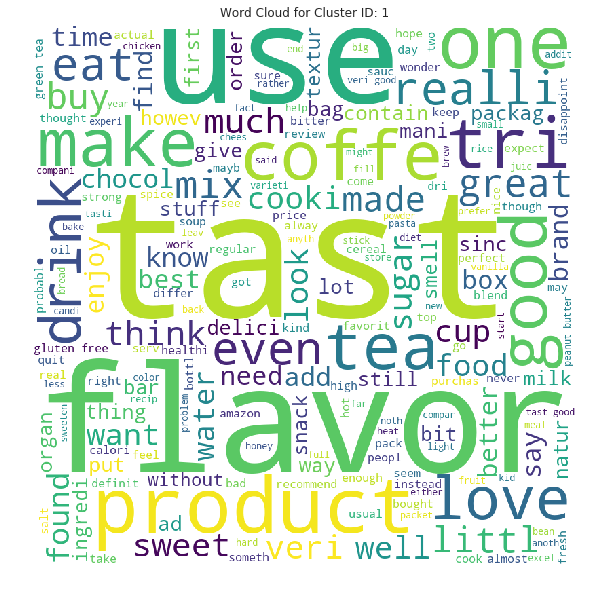

In [17]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation

%%HTML
<ul>
<li> Inertia value decreases sharply without any elbow region </li>
<li> Silhouette coefficient can be used to select the number of clusters, in this case k=2 for which we
     got the best score </li>
<li> Both clusters have many words in common. This means it is not the word but a pattern of word
     that distinguishes the cluster. We cannot simply relay on just one feature to do clustering </li>
<li> Silhouette score for this clustering is very poor score = 0.05</li>
</ul>

### [A.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [18]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/train_avg_w2v.csv',
    'train_size' : 15000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'kmeans'
}

Train df shape (15000, 52)
Shape of ->  train features :15000,51 


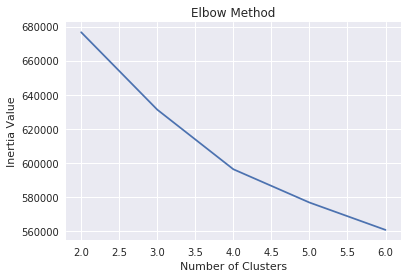

In [19]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

In [20]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.09443577923088471), (3, 0.09690401266701287), (4, 0.09556962073504416), (5, 0.08509258800240879), (6, 0.08497921702983449)]


In [21]:
ptabe_entry_a3, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 3 
Best silhoutte score for this hyper parameter : 0.096904


Id  Cluster
0  456873        1
1   81416        2
2  519340        0
3  340949        1
4  453782        1

### [A.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       2393      |      1309     |      1084     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


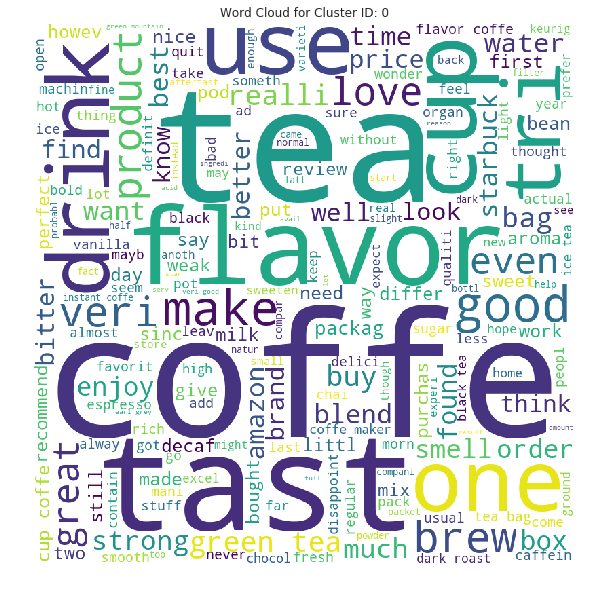

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       5831      |      2448     |      3383     |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


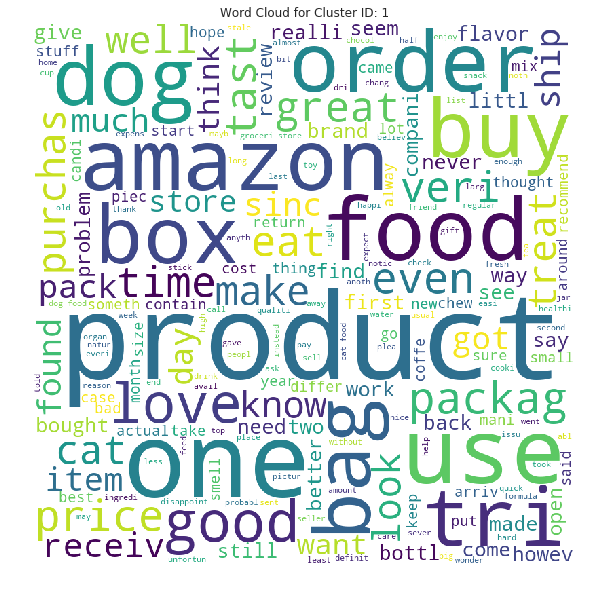

+-------------------------------------------------------------------------------+
|                                 Cluster 2 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     2      |       6776      |      3667     |      3109     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


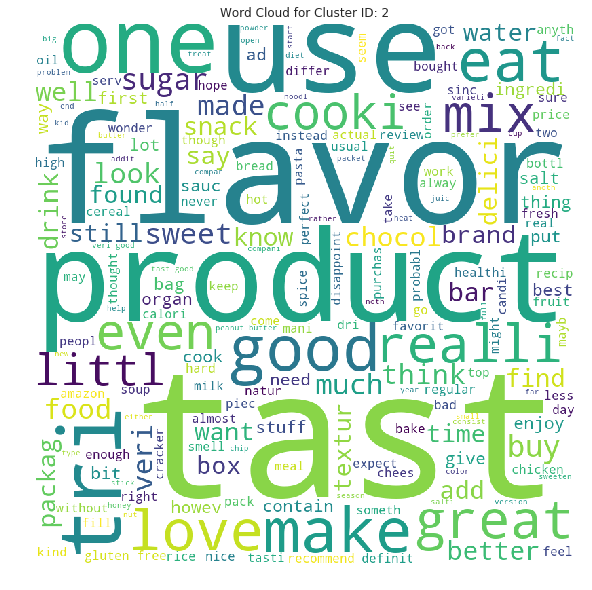

In [22]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation

%%HTML
<ul>
<li> Inertia value decreases sharply without any elbow region </li>
<li> Silhouette coefficient can be used to select the number of clusters, in this case k=3 for which we
     got the best score </li>
<li> Both clusters have many words in common. This means it s not the word but a pattern of word
     that distinguishes the cluster. We cannot simply relay on just one feature to do clustering </li>
</ul>

### [A.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [23]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/train_tf_w2v.csv',
    'train_size' : 15000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'kmeans'
}

Train df shape (15000, 52)
Shape of ->  train features :15000,51 


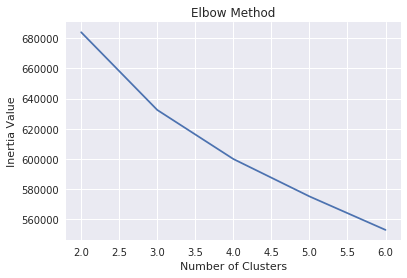

In [24]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

In [25]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.15845545839009997), (3, 0.09276123777834097), (4, 0.09837859926179662), (5, 0.09965829824548582), (6, 0.10872858814963693)]


In [26]:
ptabe_entry_a4, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 2 
Best silhoutte score for this hyper parameter : 0.158455


Id  Cluster
0  456873        0
1   81416        0
2  519340        1
3  340949        0
4  453782        0

### [A.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |      12946      |      6322     |      6624     |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


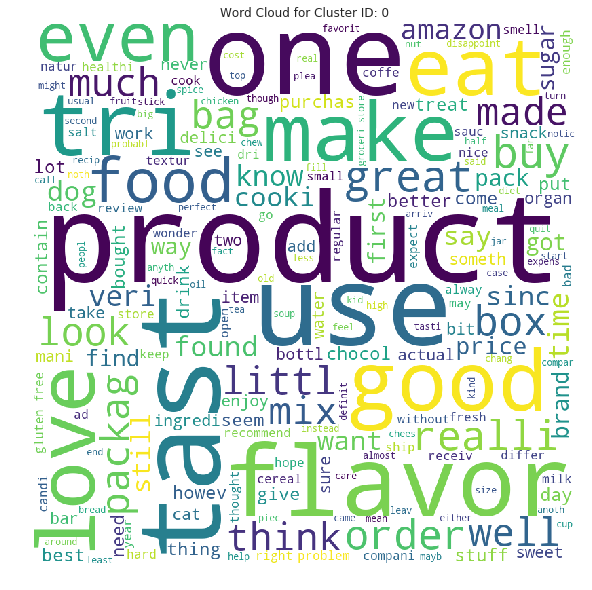

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       2054      |      1102     |      952      |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


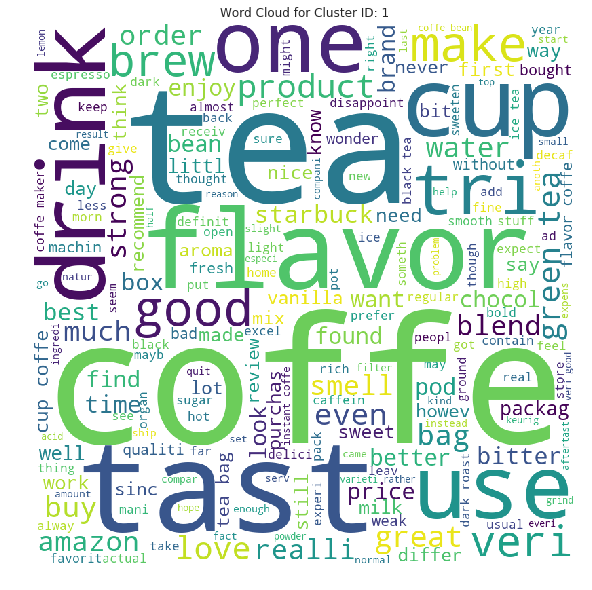

In [27]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation

%%HTML
<ul>
<li> Inertia value decreases sharply without any elbow region </li>
<li> Silhouette coefficient can be used to select the number of clusters, in this case k=2 for which we
     got the best score </li>
<li> Both clusters have many words in common. This means it is not the word but a pattern of word
     that distinguishes the cluster. We cannot simply relay on just one feature to do clustering </li>
</ul>

## [B] Agglomerative Clustering

### [B.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [28]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/train_avg_w2v.csv',
    'train_size' : 5000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'agglomerative'
}

In [29]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

Train df shape (5000, 52)
Shape of ->  train features :5000,51 


In [30]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.06843433509933095), (3, 0.06813809061058529), (4, 0.06849660399005532), (5, 0.04838840272553205), (6, 0.049787018911569246)]


In [31]:
ptabe_entry_b1, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 4
Best silhoutte score score for this hyper parameter : 0.068497


Id  Cluster
0  456873        1
1   81416        1
2  519340        2
3  340949        3
4  453782        0

### [B.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       1573      |      722      |      851      |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


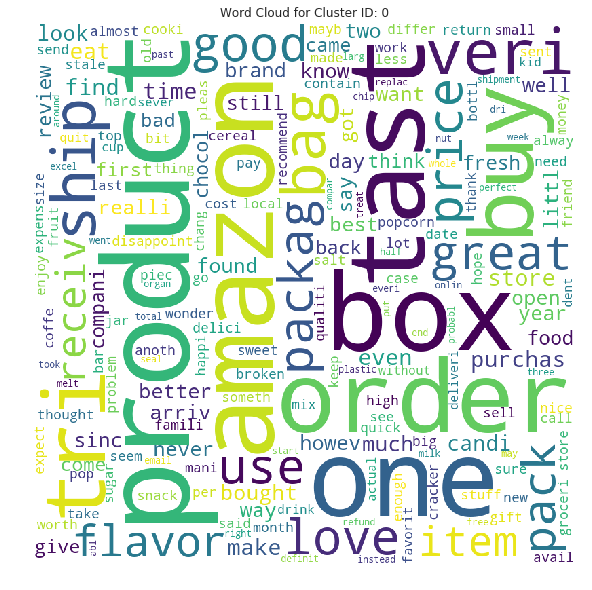

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       2177      |      1150     |      1027     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


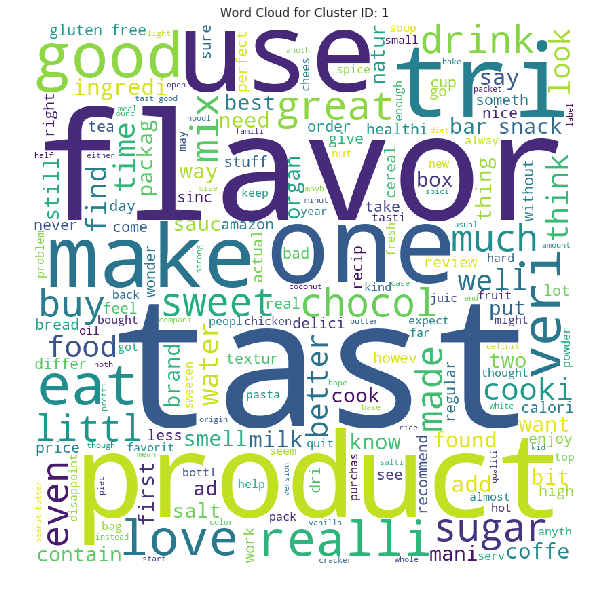

+-------------------------------------------------------------------------------+
|                                 Cluster 2 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     2      |       617       |      341      |      276      |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


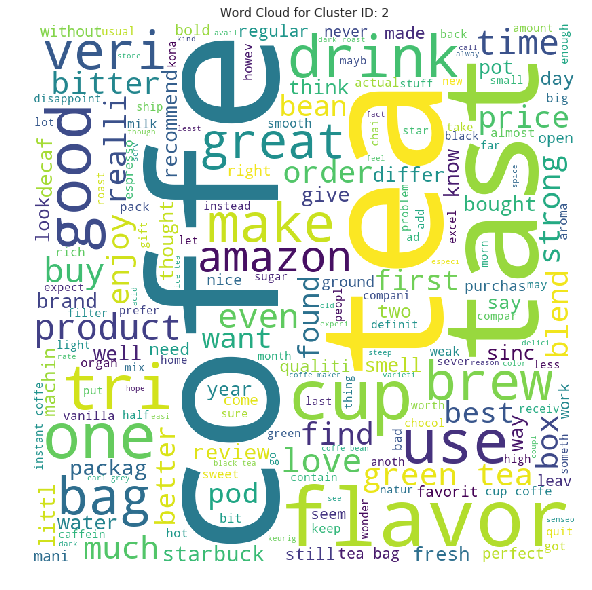

+-------------------------------------------------------------------------------+
|                                 Cluster 3 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     3      |       633       |      293      |      340      |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


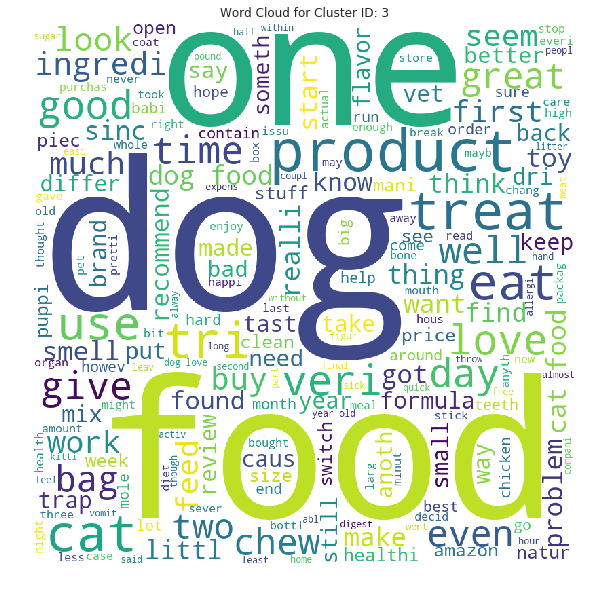

In [32]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

### [B.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [33]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/train_tf_w2v.csv',
    'train_size' : 5000,
    'hyperparam_list' : [2, 3, 4, 5, 6],
    'algo_type' : 'agglomerative'
}

In [34]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)
score_list = find_best_hyperparameter(config_dict, train_features)

Train df shape (5000, 52)
Shape of ->  train features :5000,51 


In [35]:
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [(2, 0.13184396652056307), (3, 0.1176629658795971), (4, 0.09243798682890239), (5, 0.09142444357337261), (6, 0.09452629520846241)]


In [36]:
ptabe_entry_b2, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected n_clusters : 2
Best silhoutte score score for this hyper parameter : 0.131844


Id  Cluster
0  456873        0
1   81416        0
2  519340        1
3  340949        1
4  453782        0

### [B.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       4383      |      2174     |      2209     |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


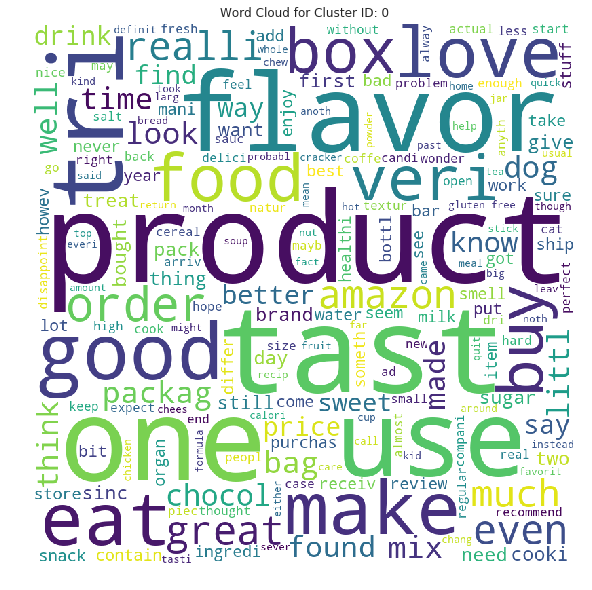

+-------------------------------------------------------------------------------+
|                                 Cluster 1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     1      |       617       |      332      |      285      |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


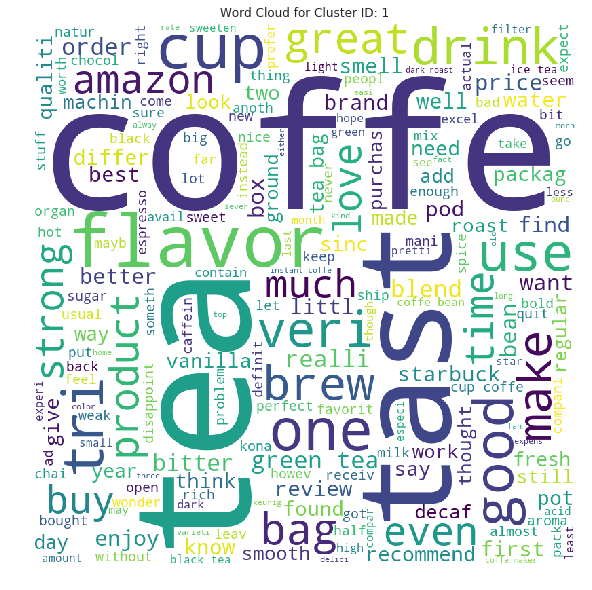

In [37]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation for SET 3 & SET 4

%%HTML
<ul>
<li> Silhouette coefficient can be used to select the number of clusters </li>
<li> The clusters have many words in common. This means its not the word but a pattern of word
     that distinguishes the cluster. We cannot simply relay on just one feature to do clustering </li>
</ul>

## [C] DBSCAN Clustering

### [C.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [38]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/train_avg_w2v.csv',
    'train_size' : 5000,
    'min_pts_list' : [40, 60, 80, 100, 120, 150],
    'hyperparam_list' : list(), # initialize this list as empty
    'algo_type' : 'dbscan'
}

In [39]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)

Train df shape (5000, 52)
Shape of ->  train features :5000,51 


### Identify the eps_val using k-distance method

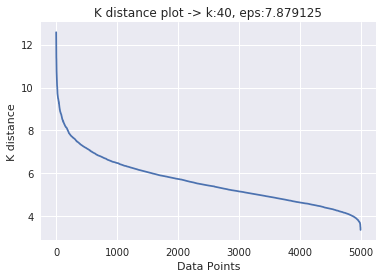

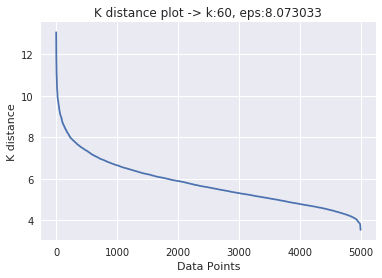

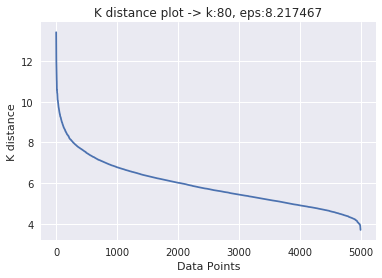

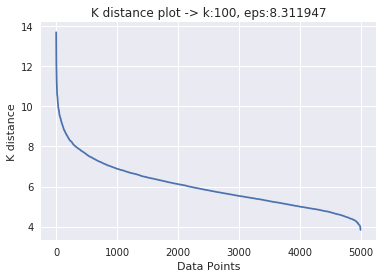

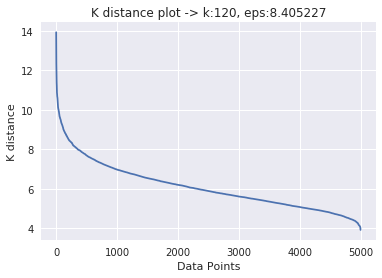

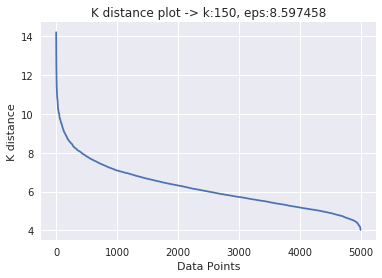

In [40]:
dist_input_df = train_features.drop(['Id'], axis=1)

# declare a list to hold all the hyperparams
hyp_param_list = list()

for min_pts in config_dict['min_pts_list']:
    mean_k_distance_list, eps_val, = get_kdistance_plot(dist_input_df, min_pts)
    hyp_param_list.append((eps_val, min_pts,))
    
# set hyper param in
config_dict['hyperparam_list'] = hyp_param_list

In [41]:
score_list = find_best_hyperparameter(config_dict, train_features)
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [((7.879124555167806, 40), 0.31914734436834824), ((8.073033236962353, 60), 0.3326226160676315), ((8.217467260251798, 80), 0.339686603702694), ((8.311946963401358, 100), 0.34464032999675426), ((8.405226754741294, 120), 0.3474856024452203), ((8.597457744499271, 150), 0.35510318993935064)]


In [42]:
ptabe_entry_c1, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected eps:8.597458,min_samples :150
Best silhoutte score score for this hyper parameter : 0.355103


Id  Cluster
0  456873        0
1   81416        0
2  519340        0
3  340949        0
4  453782        0

### [C.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

+-------------------------------------------------------------------------------+
|                                Cluster -1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     -1     |        21       |       10      |       11      |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


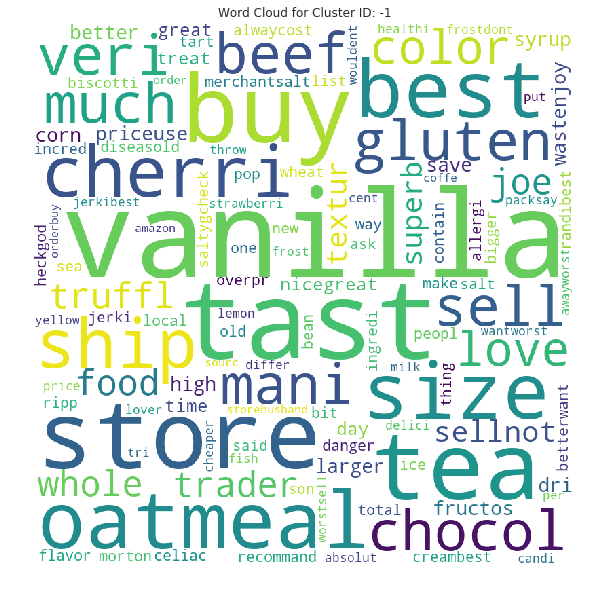

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       4979      |      2496     |      2483     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


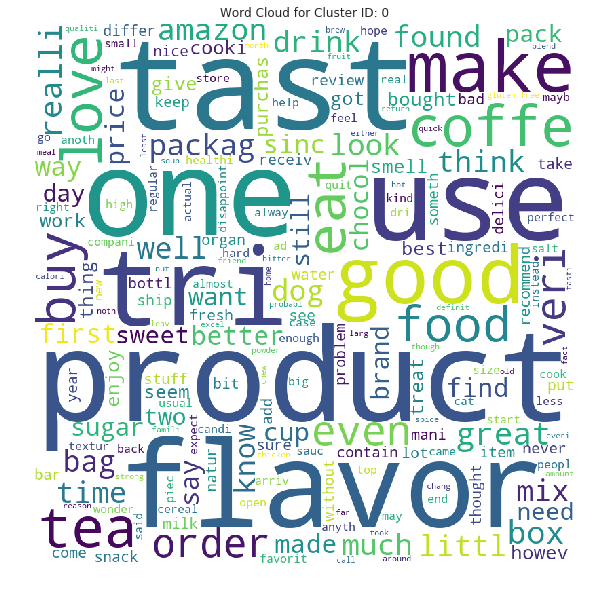

In [43]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

### [C.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [44]:
config_dict = {
    'train_csv_path' :'/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/train_tf_w2v.csv',
    'train_size' : 5000,
    'min_pts_list' : [40, 60, 80, 100, 120, 150],
    'hyperparam_list' : list(), # initialize this list as empty
    'algo_type' : 'dbscan'
}

In [45]:
train_features = preprocess_data(config_dict, scaling=True, dim_reduction=False)

Train df shape (5000, 52)
Shape of ->  train features :5000,51 


### Identify the eps_val using k-distance method

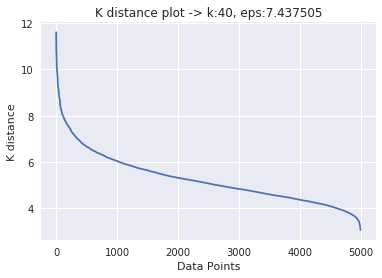

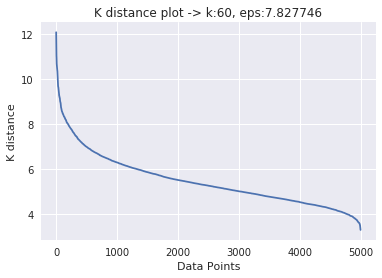

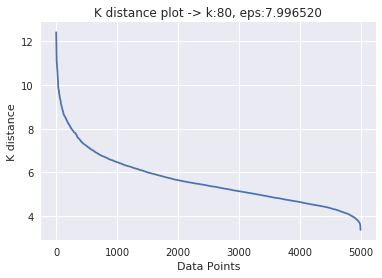

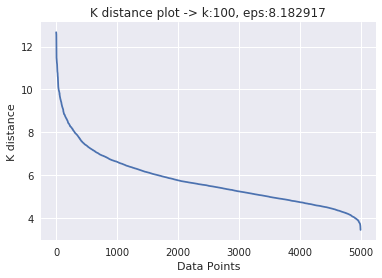

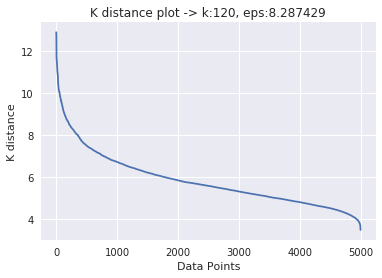

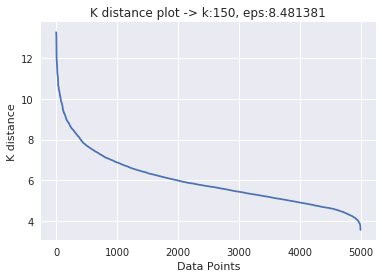

In [46]:
dist_input_df = train_features.drop(['Id'], axis=1)

# declare a list to hold all the hyperparams
hyp_param_list = list()

for min_pts in config_dict['min_pts_list']:
    mean_k_distance_list, eps_val, = get_kdistance_plot(dist_input_df, min_pts)
    hyp_param_list.append((eps_val, min_pts,))
    
# set hyper param in
config_dict['hyperparam_list'] = hyp_param_list

In [47]:
score_list = find_best_hyperparameter(config_dict, train_features)
print('Score list for this clustering :\n', score_list)

Score list for this clustering :
 [((7.437505298428046, 40), 0.3000192553249008), ((7.82774585189994, 60), 0.3425005647524928), ((7.996520296184032, 80), 0.3585504916892014), ((8.182916911351661, 100), 0.3623580782181639), ((8.287429063941415, 120), 0.38613791250942286), ((8.481381097249976, 150), 0.35059490011839123)]


In [48]:
ptabe_entry_c2, pred_df = get_cluster_id(config_dict, score_list, train_features)
pred_df.head()

Best hyper param selected eps:8.287429,min_samples :120
Best silhoutte score score for this hyper parameter : 0.386138


Id  Cluster
0  456873        0
1   81416        0
2  519340        0
3  340949        0
4  453782        0

### [C.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

+-------------------------------------------------------------------------------+
|                                Cluster -1 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     -1     |        12       |       4       |       8       |    Negative    |
+------------+-----------------+---------------+---------------+----------------+


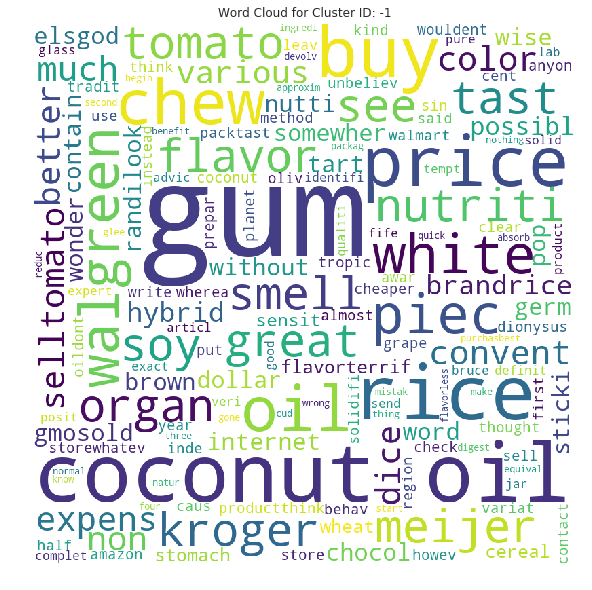

+-------------------------------------------------------------------------------+
|                                 Cluster 0 Info                                |
+------------+-----------------+---------------+---------------+----------------+
| Cluster_ID | Num Data Points | # +ve Reviews | # -ve Reviews | Majority Class |
+------------+-----------------+---------------+---------------+----------------+
|     0      |       4988      |      2502     |      2486     |    Positive    |
+------------+-----------------+---------------+---------------+----------------+


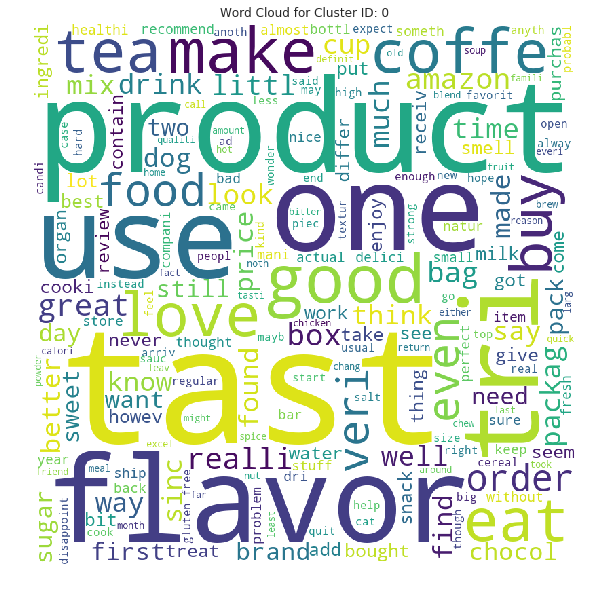

In [49]:
# get id of each review in the training data points
id_list = train_features['Id'].tolist() 
# get only the reviews which are used for training step
rev_df = read_from_DB(id_list)
# plot the word cloud for every clusters predicted
get_cluster_wordcloud(pred_df, rev_df)

## Observation

%%HTML
<ul>
<li> Silhouette coefficient can be used to select the number of clusters </li>
<li> Cluster ID -1 (Noise Points) has many words which are related to groceries such as rice, 
     cococnut oil, tomato etc.</li>
<li> DBSCAN method identified one nosiy cluster (-1) and one valid cluster (0) </li>
</ul>

# Procedure Summary

<ol>
<li> All the four datasets are column standardized before feeding to clustering algorithm </li>
<li> Best hyper parameter is selected using inertia/silhouette score. In this assignment for all
     clustering methods the clusters are selected based on the silhouette score</li>
<li> All words in a cluster are displayed using word cloud representation </li>
<li> The min_pts points are set by trial and error method </li>
<li> For DBSCAN the right number of eps value is determined using k-distance plot. From
     k-distance plot we need to identify the knee point inorder to set the eps value. </li>
</ol>

# Results Summary

In [50]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Vectorizer', 'Algorithm', 'Cluster Info {id:size}', 'Hyper-Param', 'Silhouette Score']
Pret_table.title = 'Clustering Results Summary'

In [51]:
# K-means
Pret_table.add_row(['BoW', 'K-means'] + ptabe_entry_a1)
Pret_table.add_row(['TF-IDF', 'K-means'] + ptabe_entry_a2)
Pret_table.add_row(['Avg W2V', 'K-means'] + ptabe_entry_a3)
Pret_table.add_row(['TF-IDF W2V', 'K-means'] + ptabe_entry_a4)

# Agglomerative
Pret_table.add_row(['Avg W2V', 'Agglomerative'] + ptabe_entry_b1)
Pret_table.add_row(['TF-IDF W2V', 'Agglomerative'] + ptabe_entry_b2)

# DBSCAN
Pret_table.add_row(['Avg W2V', 'DBSCAN'] + ptabe_entry_c1)
Pret_table.add_row(['TF-IDF W2V', 'DBSCAN'] + ptabe_entry_c2)

In [52]:
print(Pret_table)

+-----------------------------------------------------------------------------------------------------------------+
|                                            Clustering Results Summary                                           |
+------------+---------------+------------------------------------+----------------------------+------------------+
| Vectorizer |   Algorithm   |       Cluster Info {id:size}       |        Hyper-Param         | Silhouette Score |
+------------+---------------+------------------------------------+----------------------------+------------------+
|    BoW     |    K-means    |        {0: 13051, 1: 1949}         |            k= 2            |      0.3522      |
|   TF-IDF   |    K-means    |         {1: 8220, 0: 6780}         |            k= 2            |      0.0053      |
|  Avg W2V   |    K-means    |    {2: 6776, 1: 5831, 0: 2393}     |            k= 3            |      0.0969      |
| TF-IDF W2V |    K-means    |        {0: 12946, 1: 2054}         |     

# Conclusions

%%HTML
<ul>
<li> The best clustering obtained is from DBSCAN with silhouette value 0.3861 </li>
<li> Many clusters formed have many words in common.  This means that we cannot simply relay on words
     to get proper clustering, rather we need to try with many combination of words .</li>
</ul>